In [8]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

# Prepare dataset

Download polity dataset and pre-made 100 year dataset. The 100yr dataset will be substituted with data from TableData but we will use the methods from the TimeSeriesDataset (TSD) class.

In [11]:
polity_df = download_data("https://seshatdata.com/api/core/polities/")
dataset = TSD(file_path=f'../datasets/100_yr_dataset.xlsx')

Downloaded 839 rows
Dataset loaded from ../datasets\100_yr_dataset.xlsx


Download TableData and put all necessary data in df dataset.<br>
TSD contains datasets for social complexity variables (dataset.scv) and imputed social complexity variables (dataset.scv_imputed). Substitute both these datasets with df from TableData.

In [14]:
import pyreadr

data = pyreadr.read_r("../datasets/TableData.Rdata")
df = data['ImpSCDat']
df_agri = data['AggrSCWarAgriRelig']

add_cols = ['Metal','Project','Weapon','Animal','Armor','Defense','Cavalry','Iron','Agri','AgriLag']
for col in add_cols:
    df[col] = df_agri[col]

col_replacements = {'Time': 'Year', 'Hier':'Hierarchy', 'Gov':'Government', 'Infra':'Infrastructure',
                    'Info': 'Information'}
df = df.rename(columns=col_replacements)

# add new names and polity ids to dataset by merging with polity_df
df['PolityName'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'new_name'].values[0] if x in polity_df['name'].values else np.nan)
df['PolityID'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'id'].values[0] if x in polity_df['name'].values else np.nan)
df.drop_duplicates(subset=['PolityName', 'Year'], inplace=True)
dataset.scv = df
dataset.scv_imputed = df.copy()

Create Scale, Comp, Miltech, IronCav variables.

In [15]:
scale_cols = ['Pop','Terr','Cap']
non_scale_cols = ['Government','Infrastructure','Information','Money']

dataset.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols))
# rescale the PCA according to variable Pop

# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope

dataset.scv_imputed['Comp'] = (dataset.scv_imputed['Government']*11 + dataset.scv_imputed['Infrastructure']*12 + dataset.scv_imputed['Information']*13 + dataset.scv_imputed['Money']*6)/(11+13+12+6)

miltech_mapping = {'Miltech':{'Metal': 1, 'Project': 1, 'Weapon':1, 'Armor': 1, 'Animal': 1, 'Defense': 1}}
dataset.scv['Miltech'] = dataset.scv[miltech_mapping['Miltech']].sum(axis=1)
dataset.scv['IronCav'] = dataset.scv.apply(lambda row: row["Iron"] + row["Cavalry"], axis=1)

transfer_cols = ['Agri','AgriLag','Miltech','IronCav','Cavalry']
for col in transfer_cols:
    dataset.scv_imputed[col] = dataset.scv[col]

Explained variance by each PC:
PC1: 91.36%
PC2: 7.04%
PC3: 1.60%


C:\Users\matil\AppData\Local\Temp\ipykernel_21188\730238359.py:26: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataset.scv['Miltech'] = dataset.scv[miltech_mapping['Miltech']].sum(axis=1)


# Find Scale and Comp from subsequent 100 year period

Create dynamic regression (dr) dataset where each column has the values of Scale and Comp for the next time step (Scale_t and Comp_t respectively) as well as the change in Scale and Comp (d_Scale and d_Comp).

In [16]:
dr = dataset.scv_imputed.copy()
# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['Scale_t'] = np.nan
dr['d_Scale'] = np.nan
dr['Comp_t'] = np.nan
dr['d_Comp'] = np.nan


dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
    dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
    dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
    dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
    
    # remove rows without a value 100 yrs later
    mask = (group['Year'].shift(-1) - group['Year'] != 100)
    indices = group.index.intersection(mask[mask].index)

    dr.loc[indices,'Scale_t'] = np.nan
    dr.loc[indices,'Comp_t'] = np.nan
    dr.loc[indices,'d_Scale'] = np.nan
    dr.loc[indices,'d_Comp'] = np.nan

Function to analyze residuals

In [17]:
def analyze_residuals(values, residuals, bins):
    """
    Analyze residuals by binning comp values and calculating statistics
    
    Args:
        comp_values (array-like): Competitiveness values
        residuals (array-like): Model residuals
        bin_size (float): Size of bins (default 0.1)
    
    Returns:
        pandas.DataFrame with columns: Value, mean, SE, n, lower, upper
    """
    import pandas as pd
    import numpy as np

    bin_size = bins[1] - bins[0]
    # Initialize results
    results = []
    
    # Calculate stats for each bin
    for bin_center in bins[:-1]:
        mask = ((values >= bin_center - bin_size*2) & 
                (values < bin_center + bin_size*2))
        bin_residuals = residuals[mask]
        
        if len(bin_residuals) > 0:
            mean = np.mean(bin_residuals)
            se = np.std(bin_residuals) / np.sqrt(len(bin_residuals))
            results.append({
                'Value': bin_center + bin_size/2,
                'mean': mean,
                'SE': se,
                'n': len(bin_residuals),
                'lower': mean - se,
                'upper': mean + se
            })
    
    # Convert to dataframe
    df = pd.DataFrame(results)
    return df


# Fit Scale

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     2743.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:56:15   Log-Likelihood:                -727.86
No. Observations:                1288   AIC:                             1468.
Df Residuals:                    1282   BIC:                             1499.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.2561      0.055     22.734      0.0

C:\Users\matil\AppData\Local\Temp\ipykernel_21188\1400894348.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Comp'], inplace=True)


(0.0, 0.95)

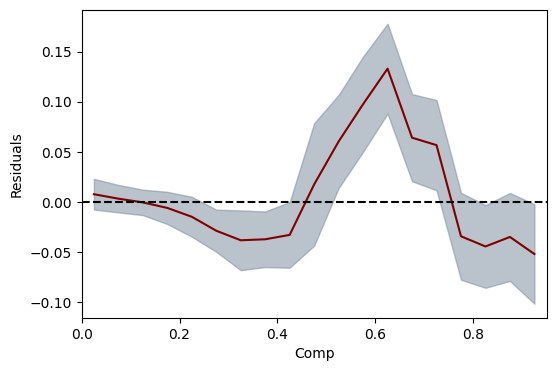

In [18]:
x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','IronCav', 'Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Comp'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

# RESIDUAL ANALYSIS

residuals = y['Scale_t'].values - predictions
comp_values = Xy['Comp'].values
bins = np.arange(0, 1, 0.05)
results_without_thresholds = analyze_residuals(comp_values, residuals, bins)
residuals_without_thresholds = residuals.copy()

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_without_thresholds['Value'], results_without_thresholds['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results_without_thresholds['Value'], results_without_thresholds['lower'], results_without_thresholds['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.xlim(0.0, 0.95)


Search for threshold in Comp

In [19]:
thresh_start = np.arange(0.3, 0.5 , 0.01)
thresh_end = np.arange(0.5, 1.0, 0.01)
x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp >= thresh_s) & (Xy.Comp < thresh_e)
        X['Comp'] = 0
        X.loc[mask, 'Comp'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'p': model.f_pvalue
        }, ignore_index=True)



C:\Users\matil\AppData\Local\Temp\ipykernel_21188\2764643668.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Local\Temp\ipykernel_21188\2764643668.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\matil\AppData\Local\Temp\ipykernel_21188\2764643668.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0
C:\Users\matil\AppData\Loc

[0.48 0.69]
                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     2315.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:57:21   Log-Likelihood:                -719.81
No. Observations:                1288   AIC:                             1454.
Df Residuals:                    1281   BIC:                             1490.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.2053      0.056     21.

C:\Users\matil\AppData\Local\Temp\ipykernel_21188\508359568.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Comp'] = 0


Text(0.5, 1.0, 'Residual of Scale')

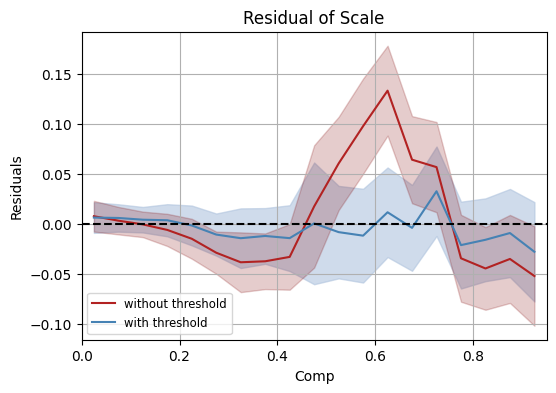

In [20]:
# find the thresholds with the lowest AIC
thresh_min = results.sort_values('AIC', ascending=True)[['thresh_start','thresh_end']].iloc[0].values
print(thresh_min)
# refit the model with the chosen thresholds
mask = (Xy.Comp >= thresh_min[0]) & (Xy.Comp < thresh_min[1])
X['Comp'] = 0
X.loc[mask, 'Comp'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

# RESIDUAL ANALYSIS and COMPARISON


residuals = y['Scale_t'].values - predictions
comp_values = Xy['Comp'].values
bins = np.arange(0, 1, 0.05)
results_with_thresholds = analyze_residuals(comp_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_without_thresholds['Value'], results_without_thresholds['mean'], color='firebrick', label = 'without threshold')
plt.plot(results_with_thresholds['Value'], results_with_thresholds['mean'], color='steelblue', label = 'with threshold')
# plt.plot(results_before['Value'], results_before['mean'], color='blue')
# plot confidence intervals
plt.fill_between(results_with_thresholds['Value'], results_with_thresholds['lower'], results_with_thresholds['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_without_thresholds['Value'], results_without_thresholds['lower'], results_without_thresholds['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(0.0, 0.95)
# plt.ylim(-0.5, 0.5)
#  add grid
plt.grid(True)
plt.title('Residual of Scale')

# Fit Comp

                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     2812.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:42:46   Log-Likelihood:                 1499.5
No. Observations:                1288   AIC:                            -2985.
Df Residuals:                    1281   BIC:                            -2949.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Comp           1.0350      0.035     29.236      0.0

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/3301586633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Scale_1'], inplace=True)


(-0.015, 0.015)

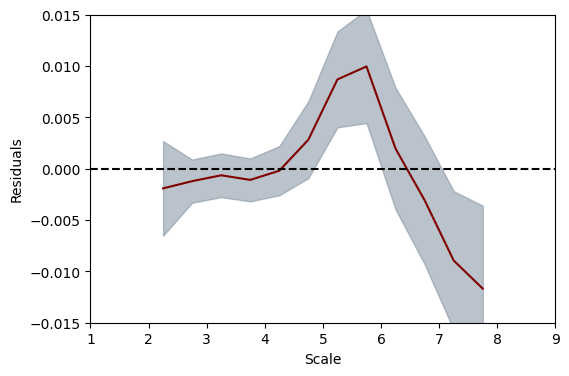

In [ ]:
x_cols = ['Comp','Agri','Miltech','AgriLag','IronCav','Comp_sq','Scale_1']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Scale_1'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())


# RESIDUAL ANALYSIS

residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8.5, 0.5)

results_without_thresholds = analyze_residuals(scale_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_without_thresholds['Value'], results_without_thresholds['mean'], color='maroon')
# plot confidence intervals
plt.fill_between(results_without_thresholds['Value'], results_without_thresholds['lower'], results_without_thresholds['upper'], color='lightslategray', alpha=0.5)
# plot zero line
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Scale')
plt.ylabel('Residuals')
plt.xlim(1, 9.)
plt.ylim(-0.015, 0.015)

Search for Scale thresholds

In [ ]:
thresh_start = np.arange(2, 6 , 0.1)
thresh_end = np.arange(6, 8, 0.1)
x_cols = ['Scale_1','Comp_sq','Agri','AgriLag','IronCav','Comp']
y_col = ['Comp_t']
Xy = dr
Xy['Comp_sq'] = Xy['Comp']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

results = pd.DataFrame(columns=['thresh_start', 'thresh_end', 'n', 'R2', 'R2_adj', 'AIC', 'p'])

for thresh_s in thresh_start:
    for thresh_e in thresh_end:
        mask = (Xy.Comp > thresh_s) & (Xy.Comp < thresh_e)
        X['Scale_1'] = 0
        X.loc[mask, 'Scale_1'] = 1

        model = sm.OLS(y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        # save results
        results = results.append({
            'thresh_start': thresh_s,
            'thresh_end': thresh_e,
            'n': len(y),
            'R2': model.rsquared,
            'R2_adj': model.rsquared_adj,
            'AIC': model.aic,
            'LeastSq': model.ssr,
            'p': model.f_pvalue
        }, ignore_index=True)


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/2862621116.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/2862621116.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/2862621116.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

Fit linear model with thresholds

In [ ]:
results.sort_values('LeastSq', ascending=True).head(10)

,thresh_start,thresh_end,n,R2,R2_adj,AIC,p,LeastSq
0,2.0,6.0,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
527,4.6,6.7,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
528,4.6,6.8,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
529,4.6,6.9,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
530,4.6,7.0,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
531,4.6,7.1,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
532,4.6,7.2,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
533,4.6,7.3,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
534,4.6,7.4,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923
535,4.6,7.5,1288.0,0.929072,0.928796,-2980.355804,0.0,7.386923


[4.6 6.7]
                            OLS Regression Results                            
Dep. Variable:                 Comp_t   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     2853.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:49:07   Log-Likelihood:                 1508.1
No. Observations:                1288   AIC:                            -3002.
Df Residuals:                    1281   BIC:                            -2966.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.0304      0.006      4.89

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/614379039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Scale_1'] = 0


Text(0.5, 1.0, 'Residuals of Comp')

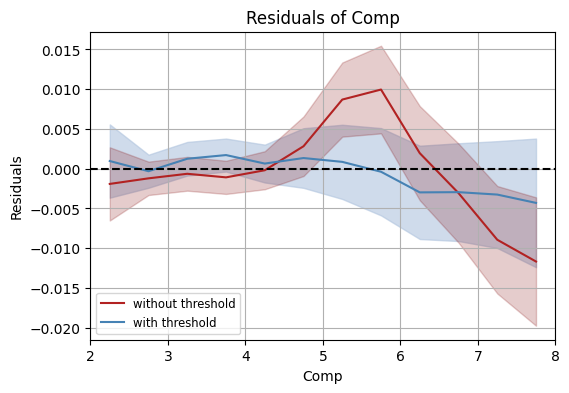

In [ ]:
thresh_min = results.sort_values('AIC', ascending=True)[['thresh_start','thresh_end']].iloc[1].values
print(thresh_min)
thresh_min = [4.6, 6.1]
mask = (Xy.Scale_1 >= thresh_min[0]) & (Xy.Scale_1 < thresh_min[1])
X['Scale_1'] = 0
X.loc[mask, 'Scale_1'] = 1

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

print(model.summary())

# RESIDUAL ANALYSIS and COMPARISON

residuals = (y['Comp_t'].values - predictions)
scale_values = Xy['Scale_1'].values
bins = np.arange(2, 8.5, 0.5)
results_with_thresholds = analyze_residuals(scale_values, residuals, bins)

plt.figure(figsize=(6, 4))
# plot mean
plt.plot(results_without_thresholds['Value'], results_without_thresholds['mean'], color='firebrick', label = 'without threshold')
plt.plot(results_with_thresholds['Value'], results_with_thresholds['mean'], color='steelblue', label = 'with threshold')

plt.fill_between(results_with_thresholds['Value'], results_with_thresholds['lower'], results_with_thresholds['upper'], color='lightsteelblue', alpha=0.6)
plt.fill_between(results_without_thresholds['Value'], results_without_thresholds['lower'], results_without_thresholds['upper'], color='maroon', alpha=0.2)

plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Comp')
plt.ylabel('Residuals')
plt.legend(loc = 'lower left', fontsize = 'small')
plt.xlim(2, 8)
#  add grid
plt.grid(True)
plt.title('Residuals of Comp')

# Changes in Comp and Scale

Average changes in Comp and Scale in 100 years. Many zeros in the dataset due to polities changing slowly and data being collected in chuncks.

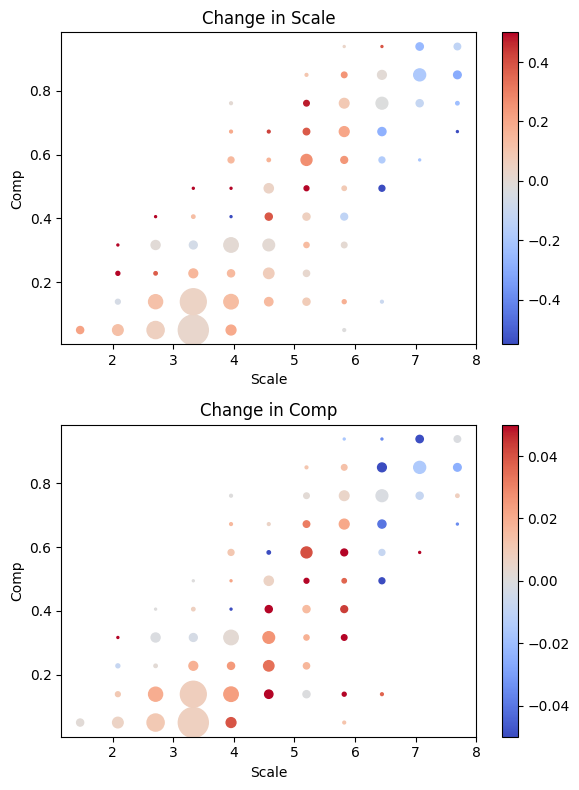

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

x_cols = ['Scale_1','Comp']
y_col = ['d_Scale','d_Comp']
Xy = dr[y_col+x_cols].dropna()

x = Xy["Scale_1"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std/2 > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std/2 > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*2, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*2, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1731759286.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1731759286.py:13: RuntimeWarning: invalid value encountered in divide
  std_1 = grid_1_std.values/grid_1.values
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1731759286.py:14: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values


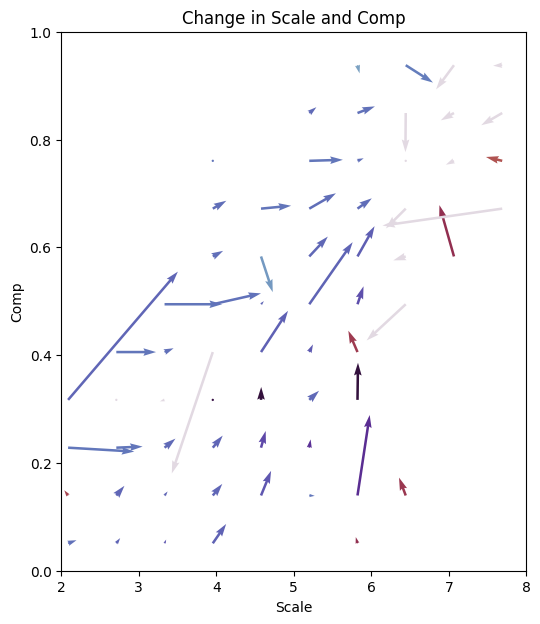

In [ ]:
import seaborn as sns


# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 1)
v = np.clip(grid_2.values, -0.1, 0.1)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1355743016.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1355743016.py:50: RuntimeWarning: invalid value encountered in divide
  std_1 = grid_1_std.values/grid_1.values
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1355743016.py:51: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1355743016.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r 

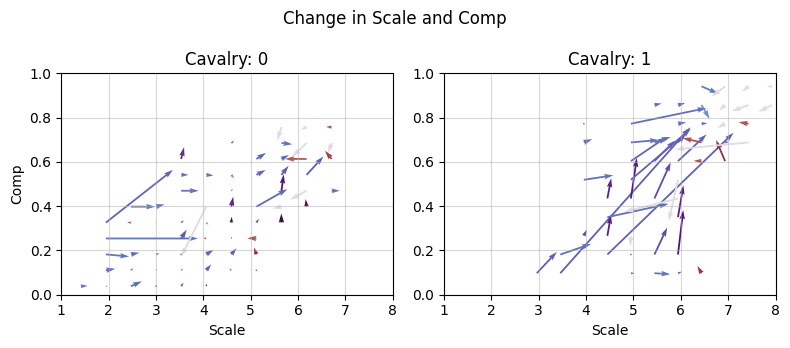

In [ ]:
import seaborn as sns

cav = [0, 1, 2]

colors = ['firebrick', 'steelblue', 'darkorange']

fig, ax = plt.subplots(1,2,figsize=(8, 3.5))
cav = [0,1]
# plt.minorticks_on()
for n,c in enumerate(cav):
    Xy = dr.loc[(dr.Cavalry == c)]
    x = Xy["Scale_1"].values
    y = Xy["Comp"].values
    z1 = Xy["d_Scale"].values
    z2 = Xy["d_Comp"].values

    grid_size = 11

    df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

    # Define the grid
    x_bins = np.linspace(min(x), max(x), grid_size + 1)
    y_bins = np.linspace(min(y), max(y), grid_size + 1)

    # Bin the data
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
    grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
    counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

    grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
    grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
    counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

    # create vector plot
    pink_r = plt.cm.get_cmap('pink_r')
    # sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
    u = np.clip(grid_1.values, -1, 1)
    v = np.clip(grid_2.values, -0.1, 0.1)
    u = grid_1.values
    v = grid_2.values

    std_1 = grid_1_std.values/grid_1.values
    std_2 = grid_2_std.values/grid_2.values

    std = np.sqrt(std_1**2 + std_2**2)
    std = np.clip(std, 0, 20)
    t_norm = np.reshape(std, -1)
    t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

    x, y = np.meshgrid(x_bins, y_bins)
    # color arrows according to angle
    color = np.arctan2(v, u)
    color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

    ax[n].quiver(x, y, u, v, scale_units='xy', angles='xy',
            color=color.reshape(-1, 4),
            alpha=1.,  scale=1.1)
    ax[n].set_xlim(1, 8)
    ax[n].set_ylim(0, 1.)
    ax[0].set_ylabel('Comp')
    ax[n].set_title(f'Cavalry: {c}')
    ax[n].grid(True,  alpha=0.5)
    
    ax[n].set_xlabel('Scale')
plt.suptitle('Change in Scale and Comp')
plt.tight_layout()
plt.show()

# Changes in Scale and Comp between polities

In [ ]:
changes = pd.DataFrame(columns = ['NGA', 'PolityName', 'Scale', 'Comp', 'd_Scale', 'd_Comp', 'Cavalry', 'd_Terr'])

scv_imp_nga = dataset.scv_imputed.groupby('NGA')
for nga, group in scv_imp_nga:
    group = group.sort_values(['Year', 'PolityID'])

    pol_nga = group.groupby('PolityID')
    polities = pol_nga['PolityName'].first()
    scales = pol_nga['Scale_1'].apply(np.mean)
    comps = pol_nga['Comp'].apply(np.mean)
    years = pol_nga['Year'].apply(np.mean)
    cav = pol_nga['Cavalry'].apply(np.mean)
    terr = pol_nga['Terr'].apply(np.mean)


    d_year = (years.shift(-1)-years)/100
    d_scales = (scales.shift(-1)-scales)/d_year
    d_comps = (comps.shift(-1) - comps)/d_year
    d_terr = (terr.shift(-1) - terr)/d_year

    df_temp = pd.DataFrame({'NGA': nga, 'PolityName':polities, 'Scale': scales, 'Comp': comps, 'd_Scale': d_scales, 'd_Comp': d_comps, 'Cavalry': cav, 'd_Terr': d_terr})
    changes = changes.append(df_temp)
changes.dropna(subset = ['d_Scale', 'd_Comp'], inplace = True)

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1281818092.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1281818092.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1281818092.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(df_temp)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1281818092.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  changes = changes.append(d

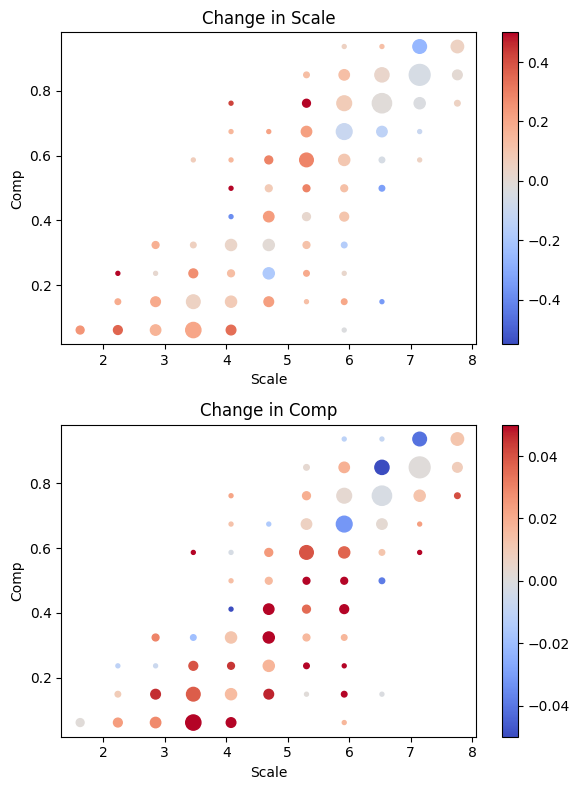

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))

Xy = changes

x = Xy["Scale"].values
y = Xy["Comp"].values
z1 = Xy["d_Scale"].values
z2 = Xy["d_Comp"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

# remove entries in grid that are not statistically significant
# grid_1[grid_1_std > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std > np.abs(grid_2)] = np.nan

# -------------------------------- AXIS 1 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[0].scatter(x.flatten(), y.flatten(), c=grid_1.values.flatten(), cmap='coolwarm', s=counts_1.values.flatten()*8, vmax = -0.5, vmin = 0.5)
cbar = plt.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Change in Scale')
ax[0].set_ylabel('Comp')
ax[0].set_xlabel('Scale')

# -------------------------------- AXIS 2 --------------------------------

x,y = np.meshgrid(x_bins, y_bins)
ax[1].scatter(x.flatten(), y.flatten(), c=grid_2.values.flatten(), cmap='coolwarm', s=counts_2.values.flatten()*8, vmax = 0.05, vmin = -0.05)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Change in Comp')
ax[1].set_ylabel('Comp')
ax[1].set_xlabel('Scale')

plt.tight_layout()
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/1507440410.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')


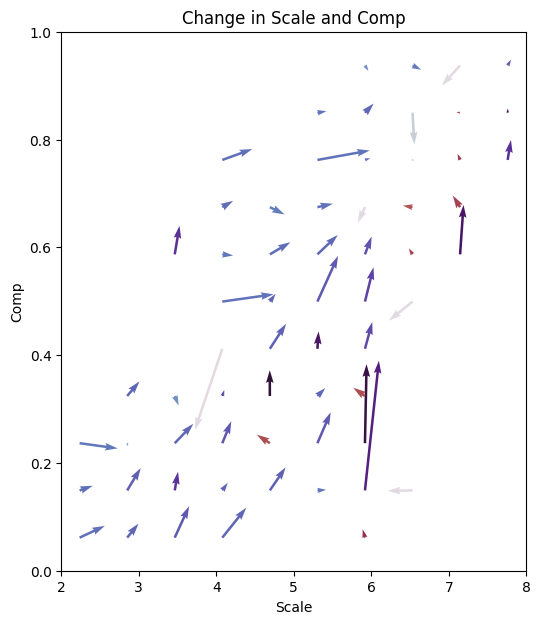

In [ ]:
import seaborn as sns
# create vector plot
fig, ax = plt.subplots(figsize=(6, 7))
pink_r = plt.cm.get_cmap('pink_r')
# sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
u = np.clip(grid_1.values, -1, 2)
v = np.clip(grid_2.values, -0.1, 0.2)
u = grid_1.values
v = grid_2.values

std_1 = grid_1_std.values/grid_1.values
std_2 = grid_2_std.values/grid_2.values

std = np.sqrt(std_1**2 + std_2**2)
std = np.clip(std, 0, 20)
t_norm = np.reshape(std, -1)
t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

x, y = np.meshgrid(x_bins, y_bins)
# color arrows according to angle
color = np.arctan2(v, u)
color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

ax.quiver(x, y, u, v, scale_units='xy', angles='xy',
           color=color.reshape(-1, 4),
           alpha=1,  scale=1.1)
ax.set_xlim(2, 8)
ax.set_ylim(0,1.)
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')
plt.title('Change in Scale and Comp')
plt.show()

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/2869313483.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r = plt.cm.get_cmap('pink_r')
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/2869313483.py:48: RuntimeWarning: invalid value encountered in divide
  std_1 = grid_1_std.values/grid_1.values
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/2869313483.py:49: RuntimeWarning: invalid value encountered in divide
  std_2 = grid_2_std.values/grid_2.values
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_66986/2869313483.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pink_r 

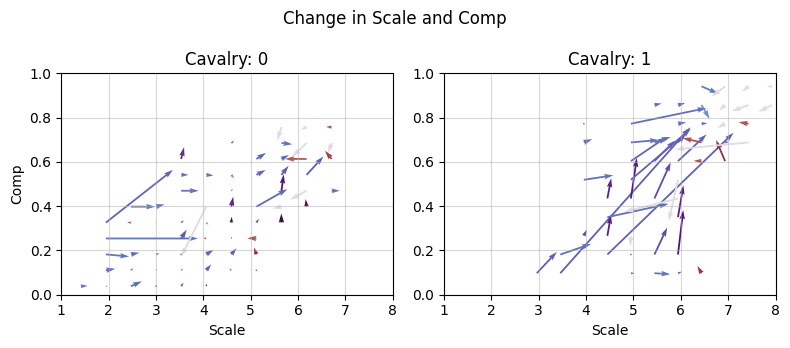

In [ ]:
import seaborn as sns

cav = [0, 1]

fig, ax = plt.subplots(1,2,figsize=(8, 3.5))
cav = [0,1]
# plt.minorticks_on()
for n,c in enumerate(cav):
    Xy = dr.loc[(dr.Cavalry == c)]
    x = Xy["Scale_1"].values
    y = Xy["Comp"].values
    z1 = Xy["d_Scale"].values
    z2 = Xy["d_Comp"].values

    grid_size = 11

    df = pd.DataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2}) 

    # Define the grid
    x_bins = np.linspace(min(x), max(x), grid_size + 1)
    y_bins = np.linspace(min(y), max(y), grid_size + 1)

    # Bin the data
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid_1 = df.groupby(['y_bin', 'x_bin'])['z1'].mean().unstack()
    grid_1_std = df.groupby(['y_bin', 'x_bin'])['z1'].std().unstack()
    counts_1 = df.groupby(['y_bin', 'x_bin'])['z1'].count().unstack()

    grid_2 = df.groupby(['y_bin', 'x_bin'])['z2'].mean().unstack()
    grid_2_std = df.groupby(['y_bin', 'x_bin'])['z2'].std().unstack()
    counts_2 = df.groupby(['y_bin', 'x_bin'])['z2'].count().unstack()

    # create vector plot
    pink_r = plt.cm.get_cmap('pink_r')
    # sns.histplot(x = dr.Scale_1, y = dr.Comp, bins=15, cmap = pink_r, alpha = 0.5, cbar = True, ax = ax)
    u = np.clip(grid_1.values, -1, 1)
    v = np.clip(grid_2.values, -0.1, 0.1)
    u = grid_1.values
    v = grid_2.values

    std_1 = grid_1_std.values/grid_1.values
    std_2 = grid_2_std.values/grid_2.values

    std = np.sqrt(std_1**2 + std_2**2)
    std = np.clip(std, 0, 20)
    t_norm = np.reshape(std, -1)
    t_scaled = (t_norm - t_norm[~np.isnan(t_norm)].min())/(t_norm[~np.isnan(t_norm)].max() - t_norm[~np.isnan(t_norm)].min())  # Normalize to 0-1

    x, y = np.meshgrid(x_bins, y_bins)
    # color arrows according to angle
    color = np.arctan2(v, u)
    color = plt.cm.twilight((color + np.pi/2) / (2*np.pi))  # Normalize and convert to RGBA

    ax[n].quiver(x, y, u, v, scale_units='xy', angles='xy',
            color=color.reshape(-1, 4),
            alpha=1.,  scale=1.1)
    ax[n].set_xlim(1, 8)
    ax[n].set_ylim(0, 1.)
    ax[0].set_ylabel('Comp')
    ax[n].set_title(f'Cavalry: {c}')
    ax[n].grid(True,  alpha=0.5)
    
    ax[n].set_xlabel('Scale')
plt.suptitle('Change in Scale and Comp')
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Scale')

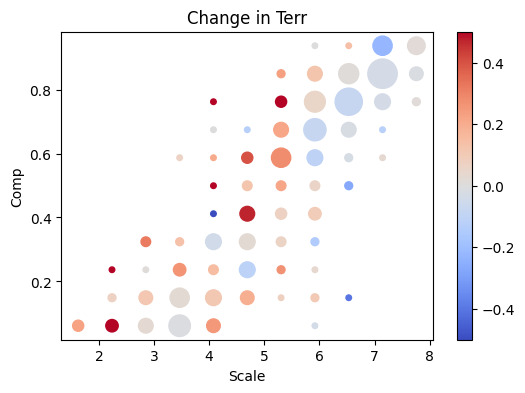

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6, 4))
Xy = changes

x = Xy["Scale"].values
y = Xy["Comp"].values
z = Xy["d_Terr"].values

grid_size = 11

df = pd.DataFrame({'x': x, 'y': y, 'z': z}) 

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)


x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['y_bin', 'x_bin'])['z'].mean().unstack()
grid_std = df.groupby(['y_bin', 'x_bin'])['z'].std().unstack()
counts = df.groupby(['y_bin', 'x_bin'])['z'].count().unstack()


# remove entries in grid that are not statistically significant
# grid_1[grid_1_std > np.abs(grid_1)] = np.nan
# grid_2[grid_2_std > np.abs(grid_2)] = np.nan

x,y = np.meshgrid(x_bins, y_bins)
ax.scatter(x.flatten(), y.flatten(), c=grid.values.flatten(), cmap='coolwarm', s=2*counts.values.flatten()*8, vmin = -0.5, vmax = 0.5)
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.set_title('Change in Terr')
ax.set_ylabel('Comp')
ax.set_xlabel('Scale')


In [ ]:
x_cols = ['Scale','Comp']
y_col = ['d_Terr']
Xy = changes
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 d_Terr   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     9.059
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           0.000147
Time:                        14:48:48   Log-Likelihood:                -202.33
No. Observations:                 347   AIC:                             410.7
Df Residuals:                     344   BIC:                             422.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale         -0.1179      0.032     -3.673      0.0